In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


###################### Preprocessing #########################
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.impute import KNNImputer


####################### Models ###########################
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


###################### Feature Reduction ########################
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from sklearn.feature_selection import RFE

###################### Metrics #######################
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, \
                  classification_report, accuracy_score,  precision_score, recall_score, f1_score, fbeta_score, make_scorer

In [ ]:
df_train = pd.read_csv("train_data.csv")
X_train, y_train = df_train.drop("num", axis=1), df_train["num"]

df_test = pd.read_csv("test_data.csv")
X_test, y_test = df_test.drop("num", axis=1), df_train["num"]

# Models plantejats

Anem a plantejar models tenint en compte que volem un classificador que utilitzi variables numèriques i categòriques i que sigui compatible amb valors NaN.

Possibles models:


1.   Regressió logística
4.   Naive Bayes classfier (laplace smoothing?)
5.   Random forest (f1-score, class_weight no cal)
6.   SVM
7.   Gradient boosting



Definim les mètriques

In [ ]:
fbeta_scorer = make_scorer(fbeta_score, beta=2)

scoring = {
    'f2': fbeta_scorer,
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

results_df = pd.DataFrame(index=[], columns= ['F2', 'Accuracy', 'F1', 'Precision', 'Recall'])
importance = pd.DataFrame(index=[])

## **Naive Bayes**



Hem de transformar les variables numèriques en gaussianes => Potser podem descartar Gaussian NB perquè les variables disten molt d'una normal encara que les transformem

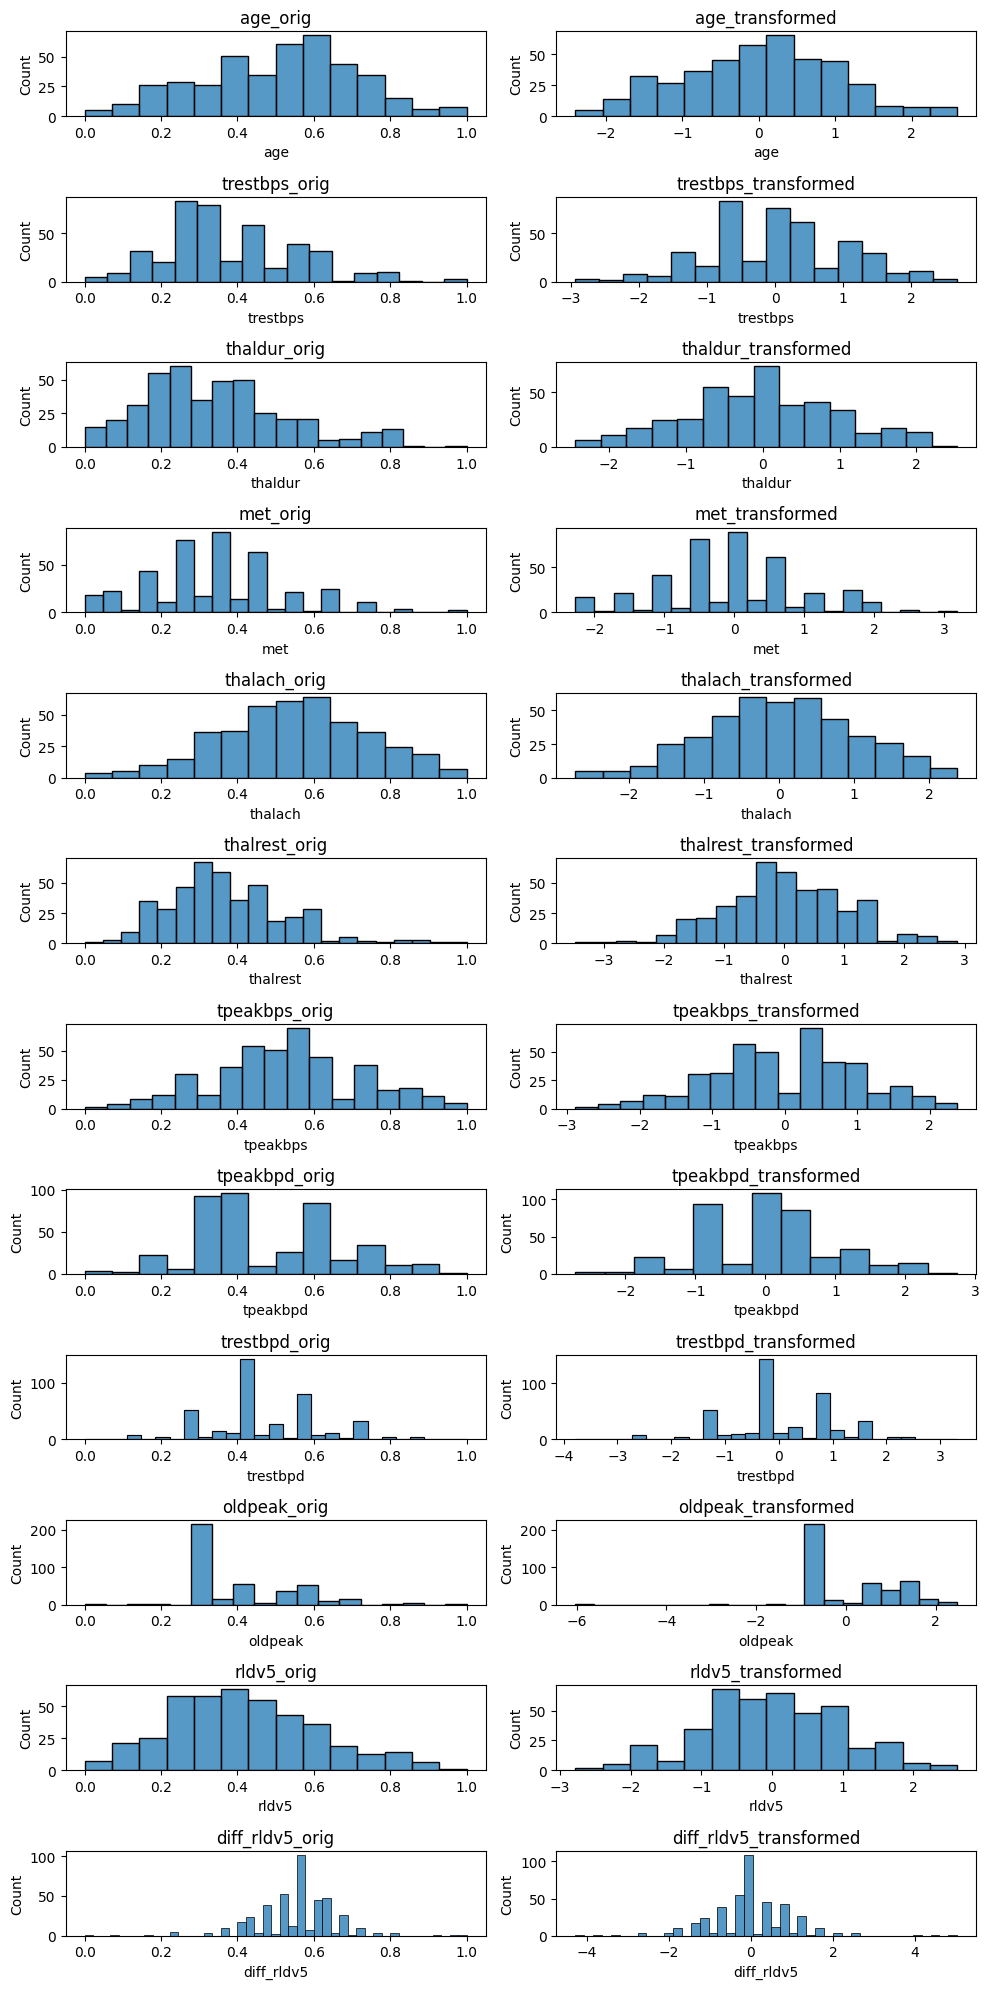

In [ ]:
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

pt = PowerTransformer(method='yeo-johnson')

X_train_transformed[num_cols] = pt.fit_transform(X_train_transformed[num_cols])
X_test_transformed[num_cols] = pt.transform(X_test_transformed[num_cols])

fig, axes = plt.subplots(len(num_cols), 2, figsize=(10, 20))


for i, c in enumerate(num_cols):
    # El primer subplot en la fila i, columna 0 para el original
    ax1 = axes[i, 0]
    sns.histplot(x=c, data=X_train, ax=ax1)
    ax1.set_title(f"{c}_orig")

    # El segundo subplot en la fila i, columna 1 para el transformado
    ax2 = axes[i, 1]
    sns.histplot(x=c, data=X_train_transformed, ax=ax2)
    ax2.set_title(f"{c}_transformed")

plt.tight_layout()
plt.show()

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=1234)

accuracies = []
precisions = []
recalls = []
f1s = []
f2s = []


for train_index, val_index in cv.split(X_train_transformed, y_train):
    _X_train, _X_val = X_train_transformed.iloc[train_index], X_train_transformed.iloc[val_index]
    _y_train, _y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    X_train_cat = _X_train.select_dtypes(include=['bool'])
    X_train_num = _X_train.select_dtypes(include=['int64', 'float64'])
    X_val_cat = _X_val.select_dtypes(include=['bool'])
    X_val_num = _X_val.select_dtypes(include=['int64', 'float64'])

    bnb = BernoulliNB()
    gnb = GaussianNB()
    gnb.fit(X_train_num, _y_train)
    bnb.fit(X_train_cat, _y_train)

    num_probs = gnb.predict_proba(X_val_num)
    cat_probs = bnb.predict_proba(X_val_cat)

    combined_probs = num_probs * cat_probs
    combined_probs = combined_probs / combined_probs.sum(axis=1, keepdims=True)
    y_pred_cv = np.argmax(combined_probs, axis=1)

    accuracies.append(accuracy_score(_y_val, y_pred_cv))
    precisions.append(precision_score(_y_val, y_pred_cv))
    recalls.append(recall_score(_y_val, y_pred_cv))
    f1s.append(f1_score(_y_val, y_pred_cv))
    f2s.append(fbeta_score(_y_val, y_pred_cv, beta = 2))


results_df.loc['Naive Bayes'] = [np.mean(f2s), np.mean(accuracies), np.mean(f1s), np.mean(precisions), np.mean(recalls)]
results_df

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.84337,0.799684,0.832822,0.816933,0.850884


In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


cv = KFold(n_splits=5, shuffle=True, random_state=1234)

accuracies = []
precisions = []
recalls = []
f1s = []
f2s = []


for train_index, val_index in cv.split(X_train_transformed, y_train):
    _X_train, _X_val = X_train_transformed.iloc[train_index], X_train_transformed.iloc[val_index]
    _y_train, _y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    X_train_cat = _X_train.select_dtypes(include=['bool'])
    X_train_num = _X_train.select_dtypes(include=['int64', 'float64'])
    X_val_cat = _X_val.select_dtypes(include=['bool'])
    X_val_num = _X_val.select_dtypes(include=['int64', 'float64'])

    qda = QuadraticDiscriminantAnalysis()
    qda.fit(_X_train, _y_train)
    y_pred_cv = qda.predict(_X_val)

    accuracies.append(accuracy_score(_y_val, y_pred_cv))
    precisions.append(precision_score(_y_val, y_pred_cv))
    recalls.append(recall_score(_y_val, y_pred_cv))
    f1s.append(f1_score(_y_val, y_pred_cv))
    f2s.append(fbeta_score(_y_val, y_pred_cv, beta = 2))


results_df.loc['QDA'] = [np.mean(f2s), np.mean(accuracies), np.mean(f1s), np.mean(precisions), np.mean(recalls)]
results_df

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
QDA,0.801474,0.761474,0.794262,0.794113,0.809238


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


cv = KFold(n_splits=5, shuffle=True, random_state=1234)

accuracies = []
precisions = []
recalls = []
f1s = []
f2s = []


for train_index, val_index in cv.split(X_train_transformed, y_train):
    _X_train, _X_val = X_train_transformed.iloc[train_index], X_train_transformed.iloc[val_index]
    _y_train, _y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    X_train_cat = _X_train.select_dtypes(include=['bool'])
    X_train_num = _X_train.select_dtypes(include=['int64', 'float64'])
    X_val_cat = _X_val.select_dtypes(include=['bool'])
    X_val_num = _X_val.select_dtypes(include=['int64', 'float64'])

    lda = LinearDiscriminantAnalysis()
    lda.fit(_X_train, _y_train)
    y_pred_cv = lda.predict(_X_val)

    accuracies.append(accuracy_score(_y_val, y_pred_cv))
    precisions.append(precision_score(_y_val, y_pred_cv))
    recalls.append(recall_score(_y_val, y_pred_cv))
    f1s.append(f1_score(_y_val, y_pred_cv))
    f2s.append(fbeta_score(_y_val, y_pred_cv, beta = 2))


results_df.loc['LDA'] = [np.mean(f2s), np.mean(accuracies), np.mean(f1s), np.mean(precisions), np.mean(recalls)]
results_df

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
QDA,0.801474,0.761474,0.794262,0.794113,0.809238
LDA,0.847546,0.816322,0.843403,0.839165,0.851039


In [ ]:
# retorna model fitejat i parametres optims
def validar_model(name, model, params, train_x, train_y, return_crossval_results = False):
  grid_search = GridSearchCV(estimator=model,
                            param_grid=params,
                            cv=5, scoring = scoring,
                            return_train_score=False,
                            refit='f2', n_jobs=-1)

  grid_search.fit(train_x, train_y)

  cross_val_results = pd.DataFrame(grid_search.cv_results_)
  filtered_results = cross_val_results

  '''for i in range(len(cross_val_results)):
        param_combination = cross_val_results.loc[i, 'params']
        mean_test_f2 = cross_val_results.loc[i, 'mean_test_f2']
        mean_test_f1 = cross_val_results.loc[i, 'mean_test_f1']
        mean_test_accuracy = cross_val_results.loc[i, 'mean_test_accuracy']
        mean_test_precision = cross_val_results.loc[i, 'mean_test_precision']
        mean_test_recall = cross_val_results.loc[i, 'mean_test_recall']

        print(f"Params: {param_combination}")
        print(f"mean_test_f2: {mean_test_f2}")
        print(f"mean_test_f1: {mean_test_f1}")
        print(f"mean_test_accuracy: {mean_test_accuracy}")
        print(f"mean_test_precision: {mean_test_precision}")
        print(f"mean_test_recall: {mean_test_recall}")
        print("-" * 40)'''

  for param, value in grid_search.best_params_.items():
    filtered_results = filtered_results[filtered_results[f'param_{param}'] == value]
  fresults = filtered_results[['mean_test_f2', 'mean_test_accuracy', 'mean_test_f1','mean_test_precision', 'mean_test_recall']].mean().values
  results_df.loc[name] = fresults

  if not return_crossval_results:
    return grid_search.best_estimator_, grid_search.best_params_
  else:
    return grid_search.best_estimator_, grid_search.best_params_, fresults



## **Regressió logística**


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1160, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklea

Params: {'C': 0, 'solver': 'liblinear'}
mean_test_f2: nan
mean_test_f1: nan
mean_test_accuracy: nan
mean_test_precision: nan
mean_test_recall: nan
----------------------------------------
Params: {'C': 0, 'solver': 'lbfgs'}
mean_test_f2: nan
mean_test_f1: nan
mean_test_accuracy: nan
mean_test_precision: nan
mean_test_recall: nan
----------------------------------------
Params: {'C': 0.0001, 'solver': 'liblinear'}
mean_test_f2: 0.8823454971530929
mean_test_f1: 0.7500058719906046
mean_test_accuracy: 0.6085771658060815
mean_test_precision: 0.6000355532337117
mean_test_recall: 1.0
----------------------------------------
Params: {'C': 0.0001, 'solver': 'lbfgs'}
mean_test_f2: 0.8766835781715383
mean_test_f1: 0.7398438429860267
mean_test_accuracy: 0.5871199082042455
mean_test_precision: 0.5871199082042455
mean_test_recall: 1.0
----------------------------------------
Params: {'C': 0.001, 'solver': 'liblinear'}
mean_test_f2: 0.8861071727332634
mean_test_f1: 0.7993122069496525
mean_test_accura

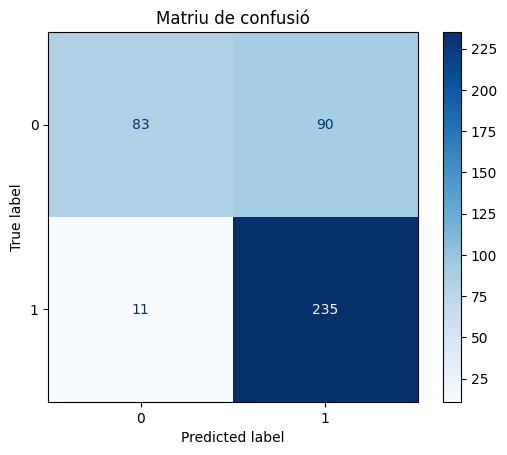

Prediccions: [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1
 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1
 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 0 0 1]
[[ 2.20411455e-02  1.12787287e-02 -4.83764675e-03  4.58143740e-03
  -3.06644416e-03 -6.56547068e-04  5.82502048e-03  3.43656892e-03
   8

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
QDA,0.801474,0.761474,0.794262,0.794113,0.809238
LDA,0.847546,0.816322,0.843403,0.839165,0.851039
Logistic regression,0.886107,0.718359,0.799312,0.687502,0.955510


In [ ]:
model = LogisticRegression(max_iter=10000, random_state=1234, n_jobs=-1)
param_grid = {
    #'C': [0.001],
    'C': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'solver': ['liblinear', 'lbfgs']
}

logreg, logreg_params = validar_model("Logistic regression", model, param_grid, X_train, y_train)

y_pred = logreg.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriu de confusió')
plt.show()

print("Prediccions:", y_pred)

print(logreg.coef_)
print("max mòdul coef:", X_train.columns[np.argmax(np.abs(logreg.coef_))])
print("min mòdul coef:", X_train.columns[np.argmin(np.abs(logreg.coef_))])

print(logreg_params)
results_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Params: {'C': 100, 'solver': 'liblinear'}
mean_test_f2: 0.8455239646395689
mean_test_f1: 0.8457167160325054
mean_test_accuracy: 0.8186460126219164
mean_test_precision: 0.8466726342710997
mean_test_recall: 0.8455510204081633
----------------------------------------
Params: {'C': 100, 'solver': 'lbfgs'}
mean_test_f2: 0.8455239646395689
mean_test_f1: 0.8457167160325054
mean_test_accuracy: 0.8186460126219164
mean_test_precision: 0.8466726342710997
mean_test_recall: 0.8455510204081633
----------------------------------------


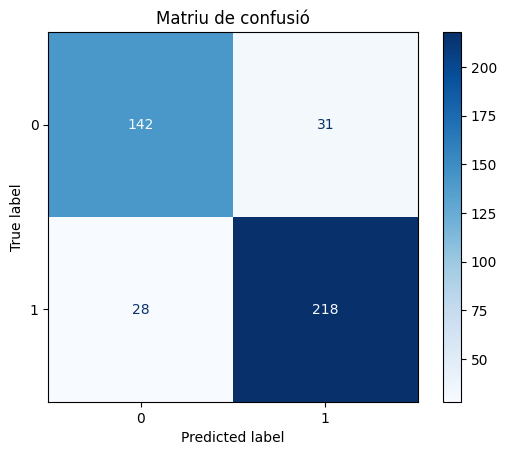

Prediccions: [0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0
 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0
 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 0
 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1
 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1
 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1
 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0
 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1
 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 1 0 1
 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1
 0 1 1 1 1 0 1 0 1 0 0 1]
[[ 0.97249162 -0.02672833 -3.42370872  3.85870696 -1.9117874  -0.17471211
   1.61344164 -2.16269904  0.21925181  4.71357017 -0.32790406 

,F2,Accuracy,F1,Precision,Recall
Logistic regression,0.845524,0.818646,0.845717,0.846673,0.845551


In [ ]:
model = LogisticRegression(max_iter=10000, random_state=1234, n_jobs=-1)
param_grid = {
    'C': [100],
    #'C': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'solver': ['liblinear', 'lbfgs']
}

logreg, logreg_params = validar_model("Logistic regression", model, param_grid, X_train, y_train)

y_pred = logreg.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriu de confusió')
plt.show()

print("Prediccions:", y_pred)

print(logreg.coef_)
print("max mòdul coef:", X_train.columns[np.argmax(np.abs(logreg.coef_))])
print("min mòdul coef:", X_train.columns[np.argmin(np.abs(logreg.coef_))])


print(logreg_params)
results_df

In [ ]:
results_df

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
KNN,0.849989,0.806713,0.838605,0.821299,0.858041
Random forest,0.870325,0.830436,0.859251,0.841999,0.878041
Gradient boosting,0.879610,0.835198,0.864262,0.840303,0.890286
SVC,0.897520,0.732731,0.810022,0.697344,0.967510
Logistic regression,0.886107,0.718359,0.799312,0.687502,0.955510


## **KNN**

In [ ]:
model = KNeighborsClassifier(n_jobs=-1)
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn, knn_params = validar_model("KNN", model, param_grid, X_train, y_train)

print(knn_params)
results_df

Params: {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
mean_test_f2: 0.6801775728757999
mean_test_f1: 0.7379848703914815
mean_test_accuracy: 0.7327882960413081
mean_test_precision: 0.8624392892968744
mean_test_recall: 0.6466938775510205
----------------------------------------
Params: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
mean_test_f2: 0.7941902986728675
mean_test_f1: 0.7904804708275852
mean_test_accuracy: 0.7518359150889271
mean_test_precision: 0.7848869417080978
mean_test_recall: 0.7968163265306123
----------------------------------------
Params: {'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}
mean_test_f2: 0.6943608169971996
mean_test_f1: 0.747834411583109
mean_test_accuracy: 0.7399311531841652
mean_test_precision: 0.8610108810108811
mean_test_recall: 0.6631020408163265
----------------------------------------
Params: {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}
mean_test_f2: 0.7978570479929744
mean_test_f1: 0.7996545880240521
mean_test_accuracy: 0.76617900172117

,F2,Accuracy,F1,Precision,Recall
Gradient boosting lololo ninguna removed,0.885766,0.847189,0.873323,0.853721,0.894367
Gradient boosting painloc_0 removed,0.885907,0.830436,0.862550,0.827553,0.902612
Gradient boosting painloc_1 removed,0.886911,0.842398,0.870358,0.844589,0.898449
Gradient boosting relrest_0 removed,0.885177,0.828084,0.860890,0.824426,0.902531
Gradient boosting cp_1 removed,0.885433,0.837608,0.867163,0.839867,0.898531
Gradient boosting relrest_1 removed,0.885000,0.785141,0.834332,0.763203,0.923020
Gradient boosting trestbps removed,0.888813,0.839960,0.869339,0.839483,0.902531
Gradient boosting cp_4 removed,0.892782,0.794779,0.841605,0.769761,0.931184
Gradient boosting met removed,0.892782,0.794779,0.841605,0.769761,0.931184
Gradient boosting thalrest removed,0.893798,0.806741,0.848616,0.783688,0.927102


## **Random forest**

Params: {'max_features': 'sqrt', 'n_estimators': 1}
mean_test_f2: 0.7722363991163148
mean_test_f1: 0.773193537420766
mean_test_accuracy: 0.7374354561101549
mean_test_precision: 0.7780555555555556
mean_test_recall: 0.772326530612245
----------------------------------------
Params: {'max_features': 'sqrt', 'n_estimators': 5}
mean_test_f2: 0.8011486713404139
mean_test_f1: 0.8017047679286768
mean_test_accuracy: 0.7685025817555937
mean_test_precision: 0.8038040396261421
mean_test_recall: 0.801061224489796
----------------------------------------
Params: {'max_features': 'sqrt', 'n_estimators': 25}
mean_test_f2: 0.8626354367476331
mean_test_f1: 0.8461662559086378
mean_test_accuracy: 0.813740676993689
mean_test_precision: 0.820555144202203
mean_test_recall: 0.8741224489795918
----------------------------------------
Params: {'max_features': 'sqrt', 'n_estimators': 50}
mean_test_f2: 0.8514441011251973
mean_test_f1: 0.8422776318448172
mean_test_accuracy: 0.8113023522662075
mean_test_precision: 

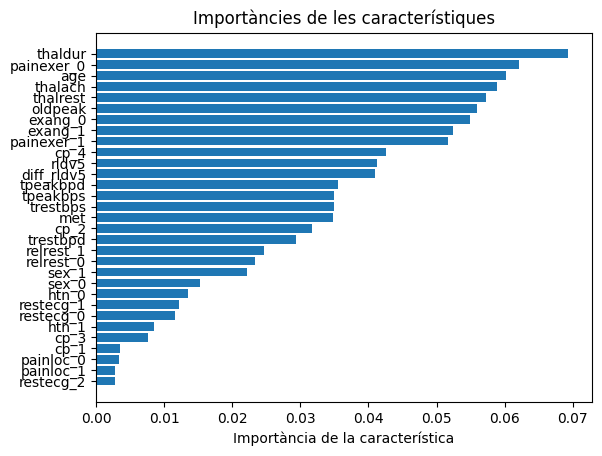

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
QDA,0.801474,0.761474,0.794262,0.794113,0.809238
LDA,0.847546,0.816322,0.843403,0.839165,0.851039
Logistic regression,0.886107,0.718359,0.799312,0.687502,0.955510
KNN,0.849989,0.806713,0.838605,0.821299,0.858041
Random forest,0.870325,0.830436,0.859251,0.841999,0.878041


In [ ]:
model = RandomForestClassifier(random_state=1234, n_jobs=-1, max_depth=None)
param_grid = {
    'n_estimators': [1, 5, 25, 50, 75, 100, 150, 200],
    'max_features': ['sqrt', 'log2', None],
    #'max_depth': [None]
}

rf, rf_params, crossval_results = validar_model("Random forest", model, param_grid, X_train, y_train, True)

print(rf_params)

plot_importances(rf)

results_df

<ipython-input-55-6e862f49ac0b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_val_results['param_max_features'] = cross_val_results['param_max_features'].astype(str)
<ipython-input-55-6e862f49ac0b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cross_val_results['param_n_estimators'] = cross_val_results['param_n_estimators'].astype(str)
<ipython-input-55-6e862f49ac0b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

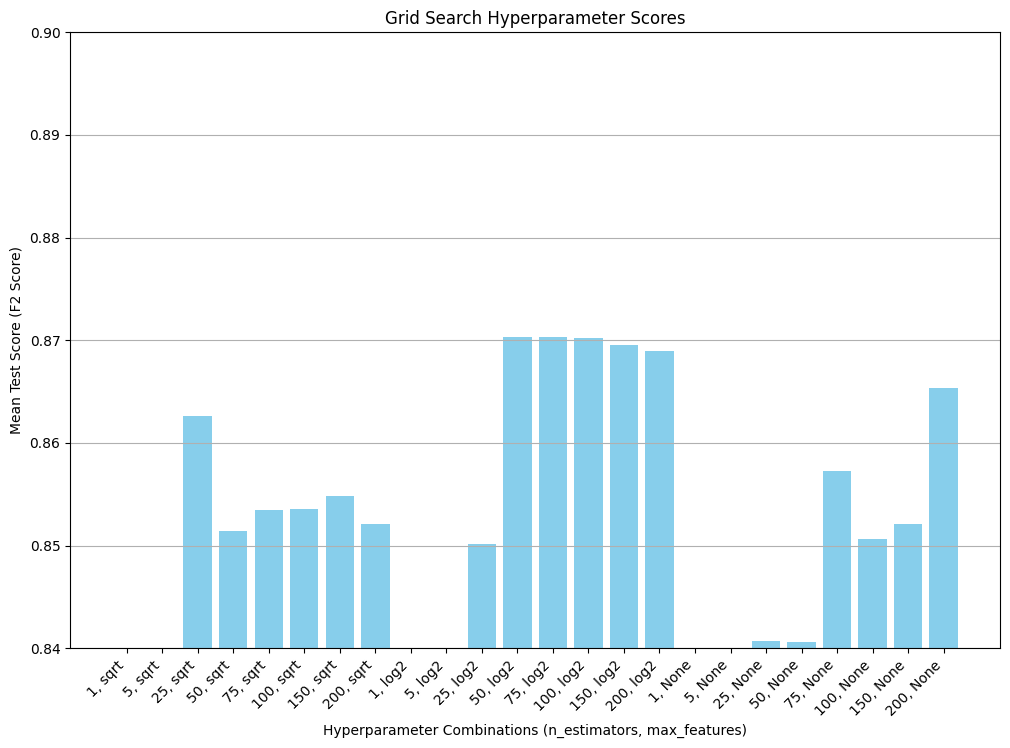

In [ ]:
cols_of_interest = ['param_n_estimators', 'param_max_features', 'mean_test_f2']
cross_val_results = crossval_results[cols_of_interest]

# Convertir las columnas de parámetros a strings para una mejor visualización
cross_val_results['param_max_features'] = cross_val_results['param_max_features'].astype(str)
cross_val_results['param_n_estimators'] = cross_val_results['param_n_estimators'].astype(str)


cross_val_results['params'] = cross_val_results['param_n_estimators'] + ', ' + cross_val_results['param_max_features']

Ncross_val_results = cross_val_results.sort_values(by='mean_test_f2', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(cross_val_results['params'], cross_val_results['mean_test_f2'], color='skyblue')
plt.xlabel('Hyperparameter Combinations (n_estimators, max_features)')
plt.ylabel('Mean Test Score (F2 Score)')
plt.ylim(0.84, 0.9)
plt.title('Grid Search Hyperparameter Scores')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


## **Gradient boosting**

In [ ]:
model = GradientBoostingClassifier(random_state=1234)

param_grid = {
    'loss': ["log_loss", "exponential"],
    'n_estimators': [1, 5, 25, 50, 75, 100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15, 1, 2],
    'max_depth': [3, 4, 5]
}

gb, gb_params, crossval_results = validar_model("Gradient boosting", model, param_grid, X_train, y_train, True)

print(gb_params)

results_df

Params: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 1}
mean_test_f2: 0.8766835781715383
mean_test_f1: 0.7398438429860267
mean_test_accuracy: 0.5871199082042455
mean_test_precision: 0.5871199082042455
mean_test_recall: 1.0
----------------------------------------
Params: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 5}
mean_test_f2: 0.8850000703679826
mean_test_f1: 0.8343324791150877
mean_test_accuracy: 0.785140562248996
mean_test_precision: 0.7632032660721186
mean_test_recall: 0.9230204081632654
----------------------------------------
Params: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 25}
mean_test_f2: 0.8596195434854419
mean_test_f1: 0.8334876271835207
mean_test_accuracy: 0.7947217441193344
mean_test_precision: 0.7945487032946247
mean_test_recall: 0.8783673469387756
----------------------------------------
Params: {'learning_rate': 0.05, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 5

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
QDA,0.801474,0.761474,0.794262,0.794113,0.809238
Gradient boosting,0.885766,0.847189,0.873323,0.853721,0.894367


## **SVM**

In [ ]:
y_train.value_counts()

num
1    246
0    173
Name: count, dtype: int64

In [ ]:
param_grid = {
    #'C': [0.001, 20],
    'C': [0.001, 0.005, 0.01, 0.05, 0.1, 1, 5, 10, 20],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 0.5, 1, 5],
    'degree': [2, 3, 4, 5]  # només pel kernel poly
}

model = SVC(random_state=1234)

svc, svc_params = validar_model("SVC", model, param_grid, X_train, y_train)

#print("max coef:", X_train.columns[np.argmax(svc.coef_)])
#print("min coef:", X_train.columns[np.argmin(svc.coef_)])

print(svc_params)

results_df

Params: {'C': 0.001, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
mean_test_f2: 0.8766835781715383
mean_test_f1: 0.7398438429860267
mean_test_accuracy: 0.5871199082042455
mean_test_precision: 0.5871199082042455
mean_test_recall: 1.0
----------------------------------------
Params: {'C': 0.001, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
mean_test_f2: 0.8766835781715383
mean_test_f1: 0.7398438429860267
mean_test_accuracy: 0.5871199082042455
mean_test_precision: 0.5871199082042455
mean_test_recall: 1.0
----------------------------------------
Params: {'C': 0.001, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
mean_test_f2: 0.8766835781715383
mean_test_f1: 0.7398438429860267
mean_test_accuracy: 0.5871199082042455
mean_test_precision: 0.5871199082042455
mean_test_recall: 1.0
----------------------------------------
Params: {'C': 0.001, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}
mean_test_f2: 0.8766835781715383
mean_test_f1: 0.7398438429860267
mean_test_accuracy: 0.587119

,F2,Accuracy,F1,Precision,Recall
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
QDA,0.801474,0.761474,0.794262,0.794113,0.809238
LDA,0.847546,0.816322,0.843403,0.839165,0.851039
Logistic regression,0.886107,0.718359,0.799312,0.687502,0.955510
KNN,0.849989,0.806713,0.838605,0.821299,0.858041
Random forest,0.870325,0.830436,0.859251,0.841999,0.878041
Gradient boosting,0.885766,0.847189,0.873323,0.853721,0.894367
SVC,0.897520,0.732731,0.810022,0.697344,0.967510


In [ ]:
results_df.sort_values(by=results_df.columns[0])

,F2,Accuracy,F1,Precision,Recall
QDA,0.801474,0.761474,0.794262,0.794113,0.809238
Naive Bayes,0.843370,0.799684,0.832822,0.816933,0.850884
LDA,0.847546,0.816322,0.843403,0.839165,0.851039
KNN,0.849989,0.806713,0.838605,0.821299,0.858041
Random forest,0.870325,0.830436,0.859251,0.841999,0.878041
Gradient boosting,0.885766,0.847189,0.873323,0.853721,0.894367
Logistic regression,0.886107,0.718359,0.799312,0.687502,0.955510
SVC,0.897520,0.732731,0.810022,0.697344,0.967510


# Feature reduction

## Gradient boosting

In [ ]:
def plot_importances(model):
  '''just for random forest and gradient boosting'''
  importances = model.feature_importances_
  indices = np.argsort(importances)
  print(X_train.columns[indices[0]])

    # Crear el gráfico
  fig, ax = plt.subplots()
  ax.barh(range(len(importances)), importances[indices])
  ax.set_yticks(range(len(importances)))
  ax.set_yticklabels(np.array(X_train.columns)[indices])
  ax.set_xlabel("Importància de la característica")
  ax.set_title("Importàncies de les característiques")
  plt.show()


painloc_1


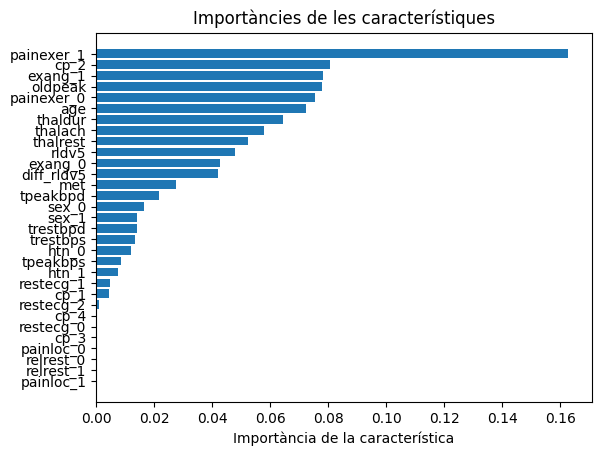

In [ ]:
plot_importances(gb)

In [ ]:
results_df = results_df.drop(results_df.index)
performance_df = performance_df.drop(performance_df.index)

In [ ]:
results_df

,F2,Accuracy,F1,Precision,Recall
Gradient boosting ninguna removed,0.885766,0.847189,0.873323,0.853721,0.894367
Gradient boosting painloc_0 removed,0.885907,0.830436,0.862550,0.827553,0.902612


In [ ]:
removed_cols = []
num_features = X_train.shape[1]

performance_df = pd.DataFrame(columns=['num_features', 'f2', 'f1', 'accuracy', 'precision', 'recall', 'removed_feature'])

model = GradientBoostingClassifier(random_state=1234)


X_copy = X_train.copy()


param_grid = {
    'loss': ["log_loss", "exponential"],
    #'n_estimators': [5],
    'n_estimators': [5, 25, 50, 75, 100],
    #'learning_rate': [1],
    'learning_rate': [0.05, 0.1, 0.15, 1, 2],
    'max_depth': [3, 4, 5]
}

least_important_feature = "ninguna"

# Iterar eliminando la característica menos importante hasta que queden la mitad
while num_features > 15:
    print("num features", num_features)
    gb, gb_params, crossval_results = validar_model(f"Gradient boosting {least_important_feature} removed", model, param_grid, X_copy, y_train, True)

    importances = gb.feature_importances_
    least_important_idx = np.argmin(importances)
    least_important_feature = X_copy.columns[least_important_idx]
    print(least_important_feature)
    performance_df = pd.concat([performance_df, pd.DataFrame({
        'num_features': num_features,
        'f2': crossval_results[0],
        'accuracy': crossval_results[1],
        'f1': crossval_results[2],
        'precision': crossval_results[3],
        'recall': crossval_results[4],
        'removed_feature': [least_important_feature]
    })], ignore_index=True)


    X_copy.drop(least_important_feature, axis=1, inplace=True)


    num_features -= 1



results_df

num features 31
painloc_0
num features 30
painloc_1
num features 29
relrest_0
num features 28
cp_1
num features 27
relrest_1
num features 26
trestbps
num features 25
cp_4
num features 24
met
num features 23
thalrest
num features 22
tpeakbps
num features 21
trestbpd
num features 20
rldv5
num features 19
diff_rldv5
num features 18
cp_2
num features 17
sex_0
num features 16
cp_3


,F2,Accuracy,F1,Precision,Recall
Gradient boosting ninguna removed,0.885766,0.847189,0.873323,0.853721,0.894367
Gradient boosting painloc_0 removed,0.885907,0.830436,0.862550,0.827553,0.902612
Gradient boosting painloc_1 removed,0.886911,0.842398,0.870358,0.844589,0.898449
Gradient boosting relrest_0 removed,0.885177,0.828084,0.860890,0.824426,0.902531
Gradient boosting cp_1 removed,0.885433,0.837608,0.867163,0.839867,0.898531
Gradient boosting relrest_1 removed,0.885000,0.785141,0.834332,0.763203,0.923020
Gradient boosting trestbps removed,0.888813,0.839960,0.869339,0.839483,0.902531
Gradient boosting cp_4 removed,0.892782,0.794779,0.841605,0.769761,0.931184
Gradient boosting met removed,0.892782,0.794779,0.841605,0.769761,0.931184
Gradient boosting thalrest removed,0.893798,0.806741,0.848616,0.783688,0.927102


In [ ]:
performance_df

,num_features,f2,f1,accuracy,precision,recall,removed_feature
0,31,0.885766,0.873323,0.847189,0.853721,0.894367,painloc_0
1,30,0.885907,0.862550,0.830436,0.827553,0.902612,painloc_1
2,29,0.886911,0.870358,0.842398,0.844589,0.898449,relrest_0
3,28,0.885177,0.860890,0.828084,0.824426,0.902531,cp_1
4,27,0.885433,0.867163,0.837608,0.839867,0.898531,relrest_1
5,26,0.885000,0.834332,0.785141,0.763203,0.923020,trestbps
6,25,0.888813,0.869339,0.839960,0.839483,0.902531,cp_4
7,24,0.892782,0.841605,0.794779,0.769761,0.931184,met
8,23,0.892782,0.841605,0.794779,0.769761,0.931184,thalrest
9,22,0.893798,0.848616,0.806741,0.783688,0.927102,tpeakbps


In [ ]:
data = {
    'num_features': [31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16],
    'f2': [0.885766, 0.885907, 0.886911, 0.885177, 0.885433, 0.885000, 0.888813, 0.892782, 0.892782, 0.893798, 0.893512, 0.893798, 0.893512, 0.893798, 0.893512, 0.893512],
    'f1': [0.873323, 0.862550, 0.870358, 0.860890, 0.867163, 0.834332, 0.869339, 0.841605, 0.841605, 0.848616, 0.843207, 0.848616, 0.843207, 0.848616, 0.843207, 0.843207],
    'accuracy': [0.847189, 0.830436, 0.842398, 0.828084, 0.837608, 0.785141, 0.839960, 0.794779, 0.794779, 0.806741, 0.797160, 0.806741, 0.797160, 0.806741, 0.797160, 0.797160],
    'precision': [0.853721, 0.827553, 0.844589, 0.824426, 0.839867, 0.763203, 0.839483, 0.769761, 0.769761, 0.783688, 0.772384, 0.783688, 0.772384, 0.783688, 0.772384, 0.772384],
    'recall': [0.894367, 0.902612, 0.898449, 0.902531, 0.898531, 0.923020, 0.902531, 0.931184, 0.931184, 0.927102, 0.931184, 0.927102, 0.931184, 0.927102, 0.931184, 0.931184],
    'removed_feature': ['painloc_0', 'painloc_1', 'relrest_0', 'cp_1', 'relrest_1', 'trestbps', 'cp_4', 'met', 'thalrest', 'tpeakbps', 'trestbpd', 'rldv5', 'diff_rldv5', 'cp_2', 'sex_0', 'cp_3']
}

performance_df = pd.DataFrame(data)

C:\Users\laiam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\laiam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\laiam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\laiam\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

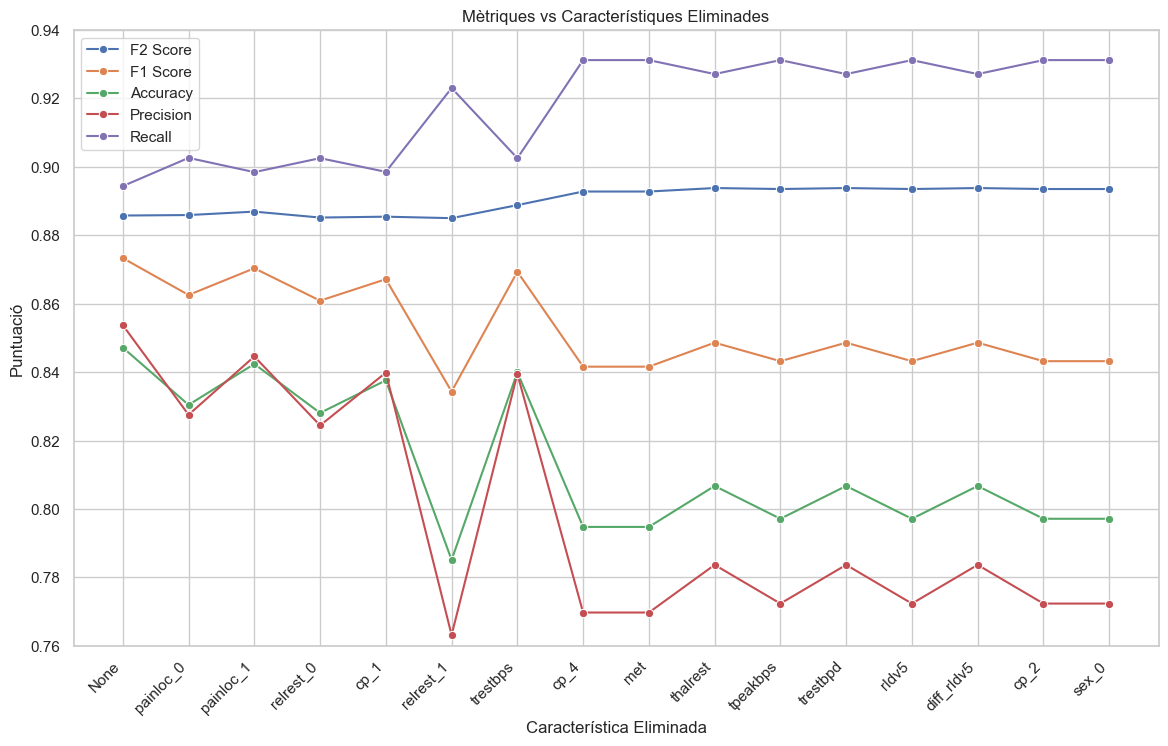

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear el DataFrame amb les dades proporcionades
data = {
    'num_features': [31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16],
    'f2': [0.885766, 0.885907, 0.886911, 0.885177, 0.885433, 0.885000, 0.888813, 0.892782, 0.892782, 0.893798, 0.893512, 0.893798, 0.893512, 0.893798, 0.893512, 0.893512],
    'f1': [0.873323, 0.862550, 0.870358, 0.860890, 0.867163, 0.834332, 0.869339, 0.841605, 0.841605, 0.848616, 0.843207, 0.848616, 0.843207, 0.848616, 0.843207, 0.843207],
    'accuracy': [0.847189, 0.830436, 0.842398, 0.828084, 0.837608, 0.785141, 0.839960, 0.794779, 0.794779, 0.806741, 0.797160, 0.806741, 0.797160, 0.806741, 0.797160, 0.797160],
    'precision': [0.853721, 0.827553, 0.844589, 0.824426, 0.839867, 0.763203, 0.839483, 0.769761, 0.769761, 0.783688, 0.772384, 0.783688, 0.772384, 0.783688, 0.772384, 0.772384],
    'recall': [0.894367, 0.902612, 0.898449, 0.902531, 0.898531, 0.923020, 0.902531, 0.931184, 0.931184, 0.927102, 0.931184, 0.927102, 0.931184, 0.927102, 0.931184, 0.931184],
    'removed_feature': ['None','painloc_0', 'painloc_1', 'relrest_0', 'cp_1', 'relrest_1', 'trestbps', 'cp_4', 'met', 'thalrest', 'tpeakbps', 'trestbpd', 'rldv5', 'diff_rldv5', 'cp_2', 'sex_0']
}

performance_df = pd.DataFrame(data)

# Eliminar l'última fila corresponent a la característica 'cp_3'
performance_df = performance_df[performance_df['removed_feature'] != 'cp_3']

# Establir l'estil del gràfic
sns.set(style="whitegrid")

# Crear una figura i eixos
plt.figure(figsize=(14, 8))

# Graficar les mètriques
sns.lineplot(data=performance_df, x='removed_feature', y='f2', label='F2 Score', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='f1', label='F1 Score', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='precision', label='Precision', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='recall', label='Recall', marker='o')

# Ajustar les etiquetes de les marques
plt.xticks(rotation=45, ha='right')

# Ajustar els límits de l'eix y per veure les diferències subtils
plt.ylim(0.76, 0.94)

# Afegir títols i etiquetes
plt.title('Mètriques vs Característiques Eliminades')
plt.xlabel('Característica Eliminada')
plt.ylabel('Puntuació')
plt.legend()

# Mostrar el gràfic
plt.show()


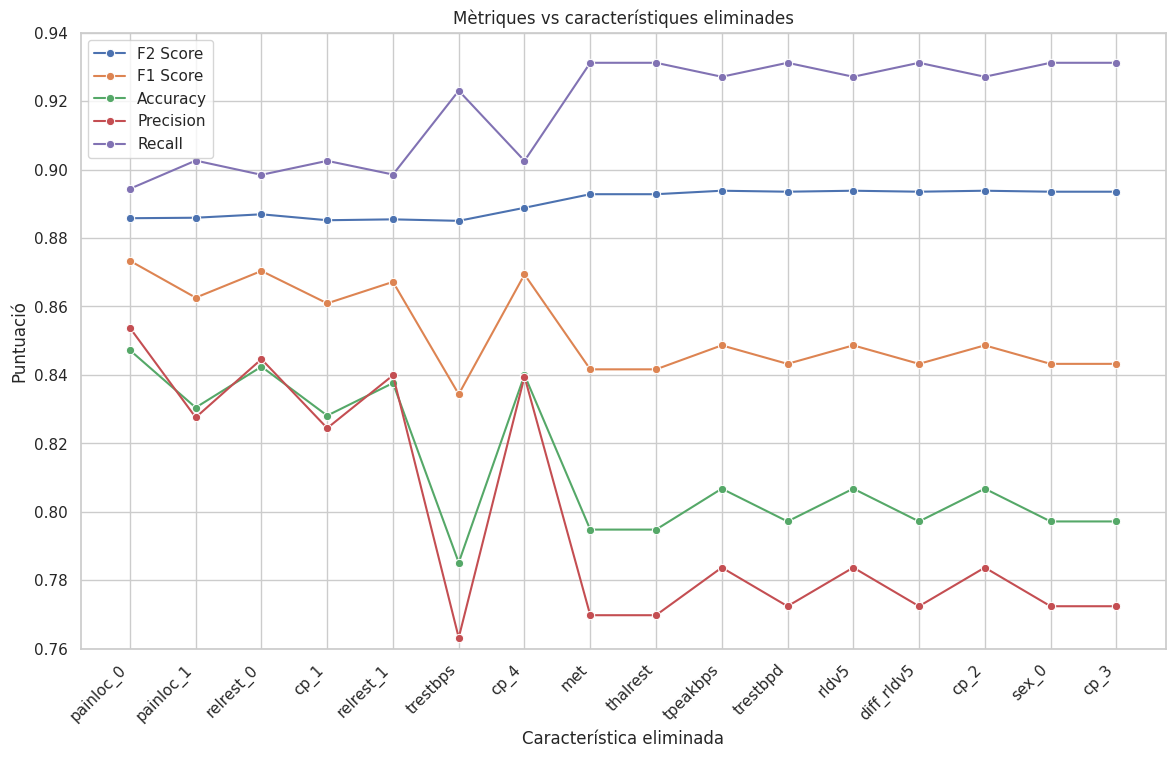

In [ ]:
sns.set(style="whitegrid")

# Crear una figura y ejes
plt.figure(figsize=(14, 8))

# Graficar las métricas
sns.lineplot(data=performance_df, x='removed_feature', y='f2', label='F2 Score', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='f1', label='F1 Score', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='accuracy', label='Accuracy', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='precision', label='Precision', marker='o')
sns.lineplot(data=performance_df, x='removed_feature', y='recall', label='Recall', marker='o')
plt.xticks(rotation=45, ha='right')
# Ajustar los límites del eje y para ver las diferencias sutiles
plt.ylim(0.76, 0.94)

# Añadir títulos y etiquetas
plt.title('Mètriques vs característiques eliminades')
plt.xlabel('Característica eliminada')
plt.ylabel('Puntuació')
plt.legend()
plt.show()

In [ ]:
X_train_def = X_train.copy()
X_train_def.drop(["painloc_0","painloc_1","relrest_0","cp_1","relrest_1","trestbps"], axis = 1, inplace = True)
model = GradientBoostingClassifier(random_state=1234)
gb_def, gb_params_def, crossval_results_def = validar_model(f"Gradient boosting DEF", model, param_grid, X_train_def, y_train, True)
results_df

,F2,Accuracy,F1,Precision,Recall
Gradient boosting ninguna removed,0.885766,0.847189,0.873323,0.853721,0.894367
Gradient boosting painloc_0 removed,0.885907,0.830436,0.862550,0.827553,0.902612
Gradient boosting painloc_1 removed,0.886911,0.842398,0.870358,0.844589,0.898449
Gradient boosting relrest_0 removed,0.885177,0.828084,0.860890,0.824426,0.902531
Gradient boosting cp_1 removed,0.885433,0.837608,0.867163,0.839867,0.898531
Gradient boosting relrest_1 removed,0.885000,0.785141,0.834332,0.763203,0.923020
Gradient boosting trestbps removed,0.888813,0.839960,0.869339,0.839483,0.902531
Gradient boosting cp_4 removed,0.892782,0.794779,0.841605,0.769761,0.931184
Gradient boosting met removed,0.892782,0.794779,0.841605,0.769761,0.931184
Gradient boosting thalrest removed,0.893798,0.806741,0.848616,0.783688,0.927102


In [ ]:
plot_importances()

# Elecció del model i estimació de l'error de generalització

In [ ]:
X_test_def = X_test.copy()
X_test_def.drop(["painloc_0","painloc_1","relrest_0","cp_1","relrest_1","trestbps"], axis = 1, inplace = True)
y_pred = gb_def.predict(X_test_def)

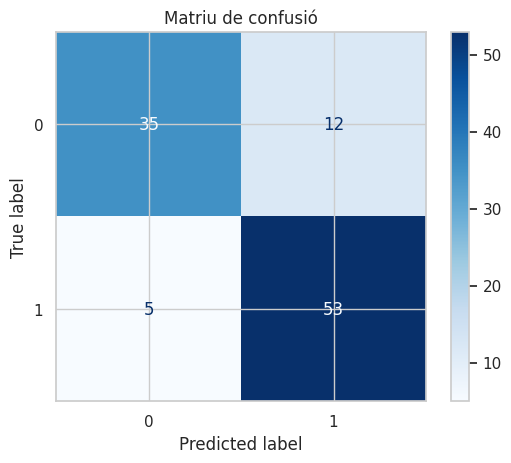

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriu de confusió')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred) # Change 'binary' to 'micro', 'macro', or 'weighted' for multi-class
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

In [ ]:
X_test.columns

y_test.iloc[X_test[X_test["sex_0"]==False].index]

499    1
583    1
21     0
421    0
355    1
      ..
480    1
308    0
194    0
509    1
606    0
Name: num, Length: 87, dtype: category
Categories (2, int64): [0, 1]

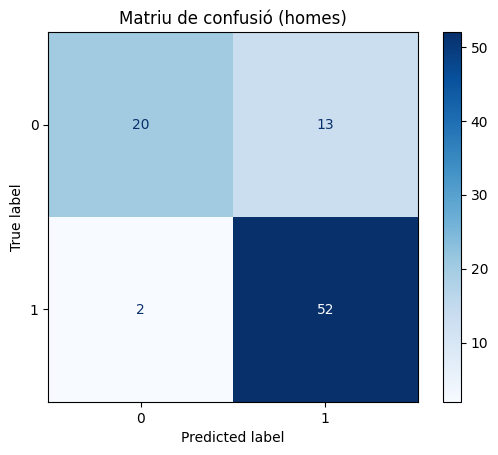

In [ ]:
conf_matrix = confusion_matrix(y_test.iloc[X_test[X_test["sex_0"]==False].index], y_pred[X_test[X_test["sex_0"]==False].index])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriu de confusió (homes)')
plt.show()

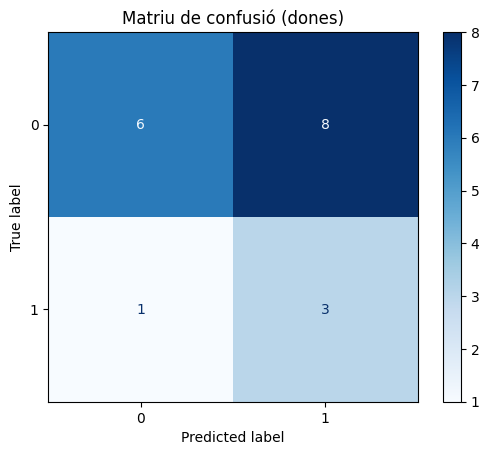

In [ ]:
conf_matrix = confusion_matrix(y_test.iloc[X_test[X_test["sex_0"]==True].index], y_pred[X_test[X_test["sex_0"]==True].index])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)

plt.title('Matriu de confusió (dones)')
plt.show()

  y_test  y_pred Prediction_Type
0    NaN       1             NaN
1    NaN       1             NaN
2    NaN       0             NaN
3    NaN       1             NaN
4    NaN       1             NaN


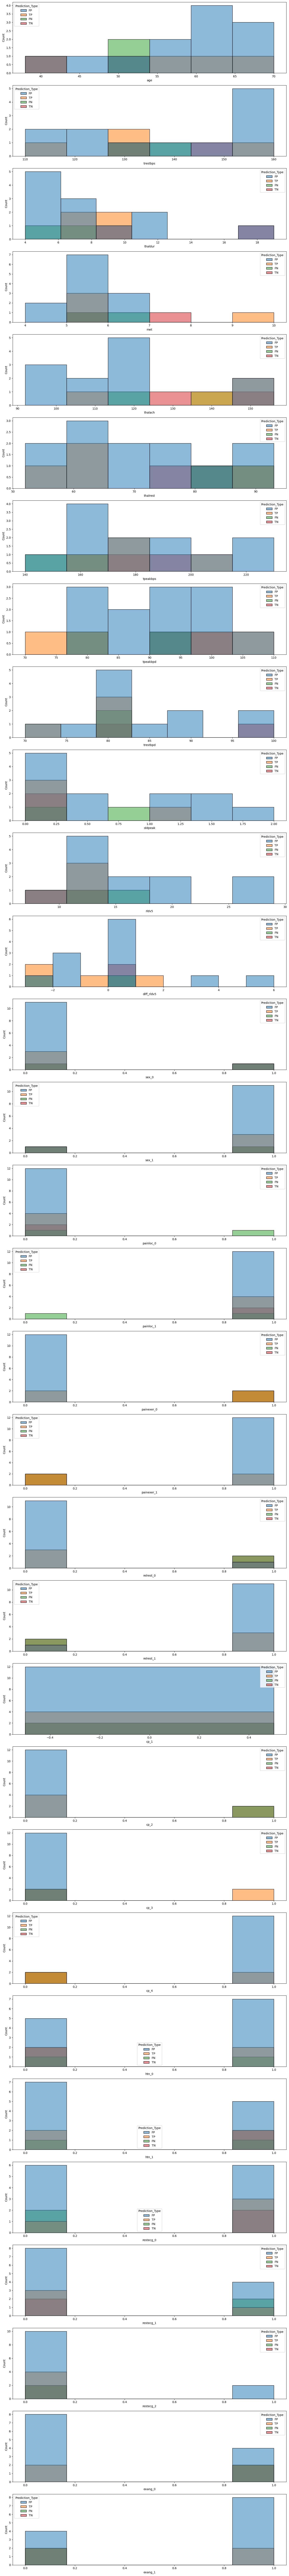

In [ ]:
X_test_copy = X_test.copy()


X_test_copy[X_test_copy.select_dtypes(include=['int64', 'float64']).columns] = scaler.inverse_transform(X_test_copy[X_test_copy.select_dtypes(include=['int64', 'float64']).columns])

X_test_copy['y_test'] = y_test
X_test_copy['y_pred'] = y_pred

X_test_copy.loc[(X_test_copy['y_test'] == 0) & (X_test_copy['y_pred'] == 1), 'Prediction_Type'] = 'FP'
X_test_copy.loc[(X_test_copy['y_test'] == 1) & (X_test_copy['y_pred'] == 0), 'Prediction_Type'] = 'FN'
X_test_copy.loc[(X_test_copy['y_test'] == 1) & (X_test_copy['y_pred'] == 1), 'Prediction_Type'] = 'TP'
X_test_copy.loc[(X_test_copy['y_test'] == 0) & (X_test_copy['y_pred'] == 0), 'Prediction_Type'] = 'TN'


# FN amb TP amb TN

# Verificar el DataFrame con la nueva columna
print(X_test_copy[['y_test', 'y_pred', 'Prediction_Type']].head())

# Plotear las distribuciones de las variables para cada tipo de predicción
fig, axes = plt.subplots(len(X_test.columns), 1, figsize=(14, 4 * len(X_test.columns)))

for i, c in enumerate([col for col in df.columns if col != "num"]):
    ax = axes.reshape(-1)[i]
    if c in df.select_dtypes(include=['category']).columns:
        a = sns.countplot(x=c,data=X_test_copy, ax=ax, hue='Prediction_Type');
    else:
        sns.histplot(x=c,data=X_test_copy, hue='Prediction_Type',ax=ax);
plt.tight_layout();

In [ ]:
# buscar aquells indexos a X_test
FP = X_test.loc[y_test.loc[(y_test == 0) & (y_pred == 1)]]
FN = X_test.loc[y_test.loc[(y_test == 1) & (y_pred == 0)]]



fig, axes = plt.subplots(7,3,figsize=(12,14));


for i, c in enumerate([col for col in df.columns if col != "num"]):
    ax = axes.reshape(-1)[i]
    if c in df.select_dtypes(include=['category']).columns:
        a = sns.countplot(x=c,data=df, ax=ax, hue='num');
    else:
        sns.histplot(x=c,data=df, hue='num',ax=ax);
plt.tight_layout();



Complete attribute documentation:
      
      0 id: patient identification number
      1 ccf: social security number (I replaced this with a dummy value of 0)
      2 age: age in years
      3 sex: sex (1 = male; 0 = female)
      4 painloc: chest pain location (1 = substernal; 0 = otherwise)
      5 painexer (1 = provoked by exertion; 0 = otherwise)
      6 relrest (1 = relieved after rest; 0 = otherwise)
      7 pncaden (sum of 5, 6, and 7)
      8 cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
     9 trestbps: resting blood pressure (in mm Hg on admission to the hospital)
     10 htn
     11 chol: serum cholestoral in mg/dl
     12 smoke: I believe this is 1 = yes; 0 = no (is or is not a smoker)
     13 cigs (cigarettes per day)
     14 years (number of years as a smoker)
     15 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
     16 dm (1 = history of diabetes; 0 = no such history)
     17 famhist: family history of coronary artery disease (1 = yes; 0 = no)
     18 restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
     19 ekgmo (month of exercise ECG reading)
     20 ekgday(day of exercise ECG reading)
     21 ekgyr (year of exercise ECG reading)
     22 dig (digitalis used furing exercise ECG: 1 = yes; 0 = no)
     23 prop (Beta blocker used during exercise ECG: 1 = yes; 0 = no)
     24 nitr (nitrates used during exercise ECG: 1 = yes; 0 = no)
     25 pro (calcium channel blocker used during exercise ECG: 1 = yes; 0 = no)
     26 diuretic (diuretic used used during exercise ECG: 1 = yes; 0 = no)
     27 proto: exercise protocol
          1 = Bruce     
          2 = Kottus
          3 = McHenry
          4 = fast Balke
          5 = Balke
          6 = Noughton
          7 = bike 150 kpa min/min  (Not sure if "kpa min/min" is what was written!)
          8 = bike 125 kpa min/min  
          9 = bike 100 kpa min/min
         10 = bike 75 kpa min/min
         11 = bike 50 kpa min/min
         12 = arm ergometer
     28 thaldur: duration of exercise test in minutes
     29 thaltime: time when ST measure depression was noted
     30 met: mets achieved
     31 thalach: maximum heart rate achieved
     32 thalrest: resting heart rate
     33 tpeakbps: peak exercise blood pressure (first of 2 parts)
     34 tpeakbpd: peak exercise blood pressure (second of 2 parts)
     35 dummy
     36 trestbpd: resting blood pressure
     37 exang: exercise induced angina (1 = yes; 0 = no)
     38 xhypo: (1 = yes; 0 = no)
     39 oldpeak = ST depression induced by exercise relative to rest
     40 slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
     41 rldv5: height at rest
     42 rldv5e: height at peak exercise
     43 ca: number of major vessels (0-3) colored by flourosopy
     44 restckm: irrelevant
     45 exerckm: irrelevant
     46 restef: rest raidonuclid (sp?) ejection fraction
     47 restwm: rest wall (sp?) motion abnormality
        0 = none
        1 = mild or moderate
        2 = moderate or severe
        3 = akinesis or dyskmem (sp?)
     48 exeref: exercise radinalid (sp?) ejection fraction
     49 exerwm: exercise wall (sp?) motion
     50 thal: A blood disorder called thalassemia 3 = normal; 6 = fixed defect; 7 = reversable defect
     51 thalsev: not used
     52 thalpul: not used
     53 earlobe: not used
     54 cmo: month of cardiac cath (sp?)  (perhaps "call")
     55 cday: day of cardiac cath (sp?)
     56 cyr: year of cardiac cath (sp?)
     57 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)
     58 lmt
     59 ladprox
     60 laddist
     61 diag
     62 cxmain
     63 ramus
     64 om1
     65 om2
     66 rcaprox
     67 rcadist
     68 lvx1: not used
     69 lvx2: not used
     70 lvx3: not used
     71 lvx4: not used
     72 lvf: not used
     73 cathef: not used
     74 junk: not used
     75 name: last name of patient